In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.utils.data import Dataset, DataLoader
from collections import OrderedDict
from spatialsoftmax import SpatialSoftmax
from torch.utils.tensorboard import SummaryWriter

import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
# Things that doesn't yet seem to be supported in pytorch:
# padding = same
# spatial softmax
class AutoEncoder_Dynamics(nn.Module):
    def __init__(self, img_res=32, z_dim=2, u_dim=2):
        super(AutoEncoder_Dynamics, self).__init__()
        
        self.img_res = img_res
        self.x_dim = img_res*img_res
        self.z_dim = z_dim
        self.u_dim = u_dim
        
        self.encoder = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=8, kernel_size=5, padding=2)), # kernel_size different than original
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(8, 8, 5, padding=2)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(8, 8, 5, padding=2)),
            ('relu3', nn.ReLU()),
            ('softmax', SpatialSoftmax(img_res, img_res, 8)),
            ('fc1', nn.Linear(8*2, 256)), # Spatial softmax will result in 2 values per channel 1 along height and 1 along width.
            ('relu4', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.5)),
            ('fc2', nn.Linear(256, 256)),
            ('relu5', nn.ReLU()),
            ('fc3', nn.Linear(256, self.z_dim))
        ]))
#         self.encoder = self.encoder.float()
        self.dynamics = nn.Sequential(OrderedDict([
            ('d_fc1', nn.Linear(self.z_dim + self.u_dim, 128)),
            ('d_relu1', nn.ReLU()),
            ('d_dropout1', nn.Dropout(p=0.5)),
            ('d_fc2', nn.Linear(128, 128)),
            ('d_relu2', nn.ReLU()),
            ('d_dropout2', nn.Dropout(p=0.5)),
            ('d_fc3', nn.Linear(128, 128)),
            ('d_relu3', nn.ReLU()),
            ('d_fc4', nn.Linear(128, self.z_dim)),
            ('d_relu4', nn.ReLU())
        ]))
#         self.dynamics = self.dynamics.float()
        self.decoder = nn.Sequential(OrderedDict([
            ('dec_fc1', nn.Linear(self.z_dim, 512)),
            ('dec_relu1', nn.ReLU()),
            ('dec_dropout1', nn.Dropout(p=0.5)),
            ('dec_fc2', nn.Linear(512, 512)),
            ('dec_relu2', nn.ReLU()),
            ('dec_dropout2', nn.Dropout(p=0.5)),
            ('dec_fc3', nn.Linear(512, 512)),
            ('dec_relu3', nn.ReLU()),
            ('dec_dropout3', nn.Dropout(p=0.5)),
            ('dec_fc4', nn.Linear(512, 512)),
            ('dec_relu4', nn.ReLU())
        ]))
#         self.decoder = self.decoder.float()
        self.environment = nn.Sequential(OrderedDict([
            ('env_conv1', nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, padding=2)), # kernel_size different than original
            ('env_relu1', nn.ReLU()),
            ('env_flat1', nn.Flatten()),
            ('env_fc1', nn.Linear(4 * self.x_dim, 512)),
            ('env_relu1', nn.ReLU()),
            ('env_dropout1', nn.Dropout(p=0.5)),
            ('env_fc2', nn.Linear(512, 512)),
            ('env_relu2', nn.ReLU()),
            ('env_dropout2', nn.Dropout(p=0.5)),
            ('env_fc3', nn.Linear(512, 512)),
            ('env_relu3', nn.ReLU()),
            ('env_dropout3', nn.Dropout(p=0.5)),
            ('env_fc4', nn.Linear(512, 512)),
            ('env_relu4', nn.ReLU())
        ]))
#         self.environment = self.environment.float()
        self.last_layer = nn.Linear(512 + 512, self.x_dim)
#         self.last_layer = self.last_layer.float()
    
    def encode(self, x_t, x_tplus):
        x_full = torch.cat((x_t, x_tplus), dim=0)
        input_enc = torch.reshape(x_full, [-1, 1, self.img_res, self.img_res])
        z_full = self.encoder(input_enc)
        return x_full, z_full

    def predict_dynamics(self, z_t, u_t):
        input_dyn = torch.cat((z_t, u_t), dim=1) #TODO: Do I have to use torch.identity after concatenation? why/not?
        z_hat_tplus = self.dynamics(input_dyn)
        return z_hat_tplus
        
    def compute_grammian(self, z_t, u_t, z_hat_tplus, retain_graph_after_last_grad=True):
        z_hat_tplus_zero = z_hat_tplus[:, 0]
        z_hat_tplus_one = z_hat_tplus[:, 1]

        grad_zh0_zt = autograd.grad(z_hat_tplus_zero, z_t,
                                    grad_outputs=torch.ones(z_hat_tplus_zero.size()),
#                                     allow_unused=True,
                                    retain_graph=True)[0]
        grad_zh1_zt = autograd.grad(z_hat_tplus_one, z_t,
                                    grad_outputs=torch.ones(z_hat_tplus_one.size()),
#                                     allow_unused=True,
                                    retain_graph=True)[0]
        grad_zh0_ut = autograd.grad(z_hat_tplus_zero, u_t,
                                    grad_outputs=torch.ones(z_hat_tplus_zero.size()),
#                                     allow_unused=True,
                                    retain_graph=True)[0]
        grad_zh1_ut = autograd.grad(z_hat_tplus_one, u_t,
                                    grad_outputs=torch.ones(z_hat_tplus_one.size()),
#                                     allow_unused=True,
                                    retain_graph=retain_graph_after_last_grad)[0]

        A = torch.stack([grad_zh0_zt, grad_zh1_zt], dim=1) # N x D_z_hat x D_z  (D_z_hat = D_z = 2)
        B = torch.stack([grad_zh0_ut, grad_zh1_ut], dim=1) # N x D_z_hat x D_c  (D_c = 2)
        c = self.__expand_dims(z_hat_tplus) - torch.bmm(A, self.__expand_dims(z_t)) - torch.bmm(B, self.__expand_dims(u_t))
        AT = torch.transpose(A, 1, 2) # Preserve the batch dimension 0 and transpose dimentions 1 and 2
        BT = torch.transpose(B, 1, 2)
        
        G = torch.bmm(A, torch.bmm(B, torch.bmm(BT, AT))) # N x D_z x D_z (remember D_z_hat = D_z)
        offset_for_invertible = (0.0001 * torch.eye(G.size()[1])).expand_as(G)
        with torch.no_grad(): # Is this needed? Probably not...
            G_inv = torch.inverse(G + offset_for_invertible) # N x D_z x D_z
            
        return G_inv, A, c
        
    def forward(self, x_t, x_tplus, x_empty, u_t):
        '''
        x_t, x_tplus, x_empty must be of shape [N, C*H*W] where, N = batch_size, 
        C = Channels, H = Height, W = Width of image.
        u is of shape [N, D_c] where D_c = Control Dimension.
        '''
        batch_size = u_t.size()[0]

        x_full, z_full = self.encode(x_t, x_tplus)
        
        z_t = z_full[:batch_size, :]
        z_tplus = z_full[batch_size:, :]

        z_hat_tplus = self.predict_dynamics(z_t, u_t)
        
        input_dec = torch.cat((z_t, z_hat_tplus), dim=0) #TODO: Again, should I use torch.identity here?
        output_dec = self.decoder(input_dec)
        
        x_empty_full = torch.cat((x_empty, x_empty), dim=0)
        input_env = torch.reshape(x_empty_full, [-1, 1, self.img_res, self.img_res]) #TODO: identity?
        output_env = self.environment(input_env)
        
        input_last = torch.cat((output_dec, output_env), dim=1)
        x_hat_full = self.last_layer(input_last)
        
        return x_full, z_t, z_tplus, x_hat_full, z_hat_tplus
        
    def compute_loss(self, u_t, x_full, z_t, z_tplus, x_hat_full, z_hat_tplus, L2_weight):
        '''
        From a typical pytorch code principles, perhaps this should be a different class
        than the net class itself but that's ok for now.
        '''
        G_inv, _, _ = self.compute_grammian(z_t, u_t, z_hat_tplus)

        z_diff = self.__expand_dims(z_hat_tplus) - self.__expand_dims(z_tplus) # N x D_z x 1
        z_diff_T = torch.transpose(z_diff, 1, 2) # N x 1 x D_z
        
        predict_loss_G = torch.sum(torch.abs(torch.bmm(z_diff_T, torch.bmm(G_inv, z_diff)))) # N x 1 before sum, scalar after sum
        predict_loss_L2 = F.mse_loss(z_hat_tplus, z_tplus,  reduction='mean')
        predict_loss = predict_loss_G * (1 - L2_weight) + predict_loss_L2 * L2_weight
        
        recon_loss = F.mse_loss(x_hat_full, x_full, reduction='mean')
        total_loss = predict_loss + recon_loss
        
        return total_loss, predict_loss_G, predict_loss_L2, recon_loss
    
    def __expand_dims(self, input):
        return input.unsqueeze(input.dim())
        
class CollisionChecker(nn.Module):
    def __init__(self, img_res=32, z_dim=2, u_dim=2):
        super(CollisionChecker, self).__init__()
        self.img_res = img_res
        self.x_dim = img_res*img_res
        self.z_dim = z_dim
        self.u_dim = u_dim
        conv_filters = 10
        padding=3
        kernel_size=7
        fc_dim = 128
        self.imageConvLayer = nn.Sequential(OrderedDict([
            ('conv1', nn.Conv2d(in_channels=1, out_channels=conv_filters, kernel_size=kernel_size, padding=padding)), # kernel_size different than original
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(conv_filters, conv_filters, kernel_size, padding)),
            ('relu2', nn.ReLU()),
            ('conv3', nn.Conv2d(conv_filters, conv_filters, kernel_size, padding)),
            ('relu3', nn.ReLU()),
            ('flat1', nn.Flatten()),
            ('fc1', nn.Linear(conv_filters*self.x_dim, 4*fc_dim)),
            ('relu4', nn.ReLU())
        ]))
        self.latentDenseLayer = nn.Sequential(OrderedDict([
            ('fc2', nn.Linear(2*self.z_dim, 4*fc_dim)),
            ('relu5', nn.ReLU())
        ]))
        self.finalDenseLayer = nn.Sequential(OrderedDict([
            ('fc3', nn.Linear(8*fc_dim, fc_dim)),
            ('relu6', nn.ReLU()),
            ('dropout1', nn.Dropout(p=0.5)),
            ('fc4', nn.Linear(fc_dim, fc_dim)),
            ('relu7', nn.ReLU()),
            ('dropout2', nn.Dropout(p=0.5)),
            ('fc5', nn.Linear(fc_dim, fc_dim)),
            ('relu8', nn.ReLU()),
            ('dropout3', nn.Dropout(p=0.5)),
            ('fc6', nn.Linear(fc_dim, fc_dim)),
            ('relu9', nn.ReLU()),
            ('dropout4', nn.Dropout(p=0.5)),
            ('fc7', nn.Linear(fc_dim, fc_dim)),
            ('relu10', nn.ReLU()),
            ('fc8', nn.Linear(fc_dim, 1))
        ]))
    
    def image_representation(self, x):
        inputs_img = torch.reshape(x, [-1, 1, self.img_res, self.img_res])
        img_dense_out = self.imageConvLayer(inputs_img)
        
    def forward(self, z1, z2, img_dense_out):        
        inputs_lat = torch.cat((z1, z2), dim=1)
        lat_dense_out = self.latentDenseLayer(inputs_lat)
        
        inputs_final = torch.cat((lat_dense_out, img_dense_out), dim=1)
        collision_prediction = self.finalDenseLayer(inputs_final)
        
        return collision_prediction
    
    def compute_loss(self, labels, logits):
        return F.binary_cross_entropy_with_logits(logits, labels, reduction='sum')
    
#     def train(self, loss, lr=1e-4):
#         optimizer = optim.Adam(self.parameters(), lr=lr)
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

In [9]:
enc_dyn_net = AutoEncoder_Dynamics()
ed_params = list(enc_dyn_net.parameters())
print (len(ed_params))
print(ed_params[0].data.type())

cc_net = CollisionChecker()
c_params = list(cc_net.parameters())
print (len(c_params))

41
torch.FloatTensor
22


In [10]:
for params in [ed_params, c_params]:
    print ('Parameters:')
    for i in range(len(params)):
        print ('{}: {}'.format(params[i].type(), params[i].size()))

Parameters:
torch.FloatTensor: torch.Size([8, 1, 5, 5])
torch.FloatTensor: torch.Size([8])
torch.FloatTensor: torch.Size([8, 8, 5, 5])
torch.FloatTensor: torch.Size([8])
torch.FloatTensor: torch.Size([8, 8, 5, 5])
torch.FloatTensor: torch.Size([8])
torch.FloatTensor: torch.Size([1])
torch.FloatTensor: torch.Size([256, 16])
torch.FloatTensor: torch.Size([256])
torch.FloatTensor: torch.Size([256, 256])
torch.FloatTensor: torch.Size([256])
torch.FloatTensor: torch.Size([2, 256])
torch.FloatTensor: torch.Size([2])
torch.FloatTensor: torch.Size([128, 4])
torch.FloatTensor: torch.Size([128])
torch.FloatTensor: torch.Size([128, 128])
torch.FloatTensor: torch.Size([128])
torch.FloatTensor: torch.Size([128, 128])
torch.FloatTensor: torch.Size([128])
torch.FloatTensor: torch.Size([2, 128])
torch.FloatTensor: torch.Size([2])
torch.FloatTensor: torch.Size([512, 2])
torch.FloatTensor: torch.Size([512])
torch.FloatTensor: torch.Size([512, 512])
torch.FloatTensor: torch.Size([512])
torch.FloatTensor:

In [4]:
# Data loader
class NumpyCsvDataSet(Dataset):
    def __init__(self, csv_file):
        self.csv_file = csv_file
        self.data = np.loadtxt(csv_file, delimiter=',', dtype=float)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index]

In [5]:
dynamics_training = NumpyCsvDataSet('dynamics_train.csv')
dynamics_test = NumpyCsvDataSet('dynamics_test.csv')

In [6]:
dyn_training_loader = DataLoader(dynamics_training, batch_size=50, shuffle=True)
dyn_test_loader = DataLoader(dynamics_training, batch_size=25, shuffle=False)

In [7]:
x_dim = 32*32
u_dim = 2
img_res = 32

In [27]:
## Training auto encoder and dynamics network
epochs = 100

enc_dyn_net = AutoEncoder_Dynamics()
enc_dyn_net.train()
optimizer = optim.Adam(enc_dyn_net.parameters(), lr=1e-4)

expt_prefix = 'AutoEncoderDynamics-Training-'
expt_name = expt_prefix + time.strftime('%m-%d-%H-%M-%S')
writer = SummaryWriter('runs/' + expt_name)

running_loss = np.array([0.0, 0.0, 0.0, 0.0])
for epoch in range(epochs):
    for i, data in enumerate(dyn_training_loader, 0):
        data = data.float()
        x_t = data[:, :x_dim]
        x_tplus = data[:, x_dim:2*x_dim]
        x_empty = data[:, 2*x_dim:3*x_dim]
        u_t = data[:, 3*x_dim:]
        u_t.requires_grad_()
        
#         if (epoch==0 and i==0):
#             writer.add_graph(enc_dyn_net, (x_t, x_tplus, x_empty, u_t))
            
        x_full, z_t, z_tplus, x_hat_full, z_hat_tplus = enc_dyn_net(x_t, x_tplus, x_empty, u_t)
        l2_weight = 1.0 if epoch < 10 else 0.0 # Can use a more sophisticated L2_weight formulation
        total_loss, predict_loss_G, predict_loss_L2, recon_loss = enc_dyn_net.compute_loss(u_t, x_full, z_t, z_tplus, x_hat_full, z_hat_tplus, l2_weight)
        
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        
        running_loss += np.array([total_loss.item(), predict_loss_G.item(), predict_loss_L2.item(), recon_loss.item()])
        if i % 100 == 99:
            avg_loss = running_loss / 100
            print ('[%d, %5d] loss: %.3f' % (epoch+1, i+1, avg_loss[0]))
            index = epoch * len(dyn_training_loader) + i
            writer.add_scalar('training_loss', avg_loss[0], index)
            writer.add_scalar('predict_loss_G', avg_loss[1], index)
            writer.add_scalar('predict_loss_L2', avg_loss[2], index)
            writer.add_scalar('recon_loss', avg_loss[3], index)
            running_loss[:] = 0.0

[1,   100] loss: 747.163
[1,   200] loss: 548.190
[2,   100] loss: 473.249
[2,   200] loss: 405.209
[3,   100] loss: 359.356
[3,   200] loss: 336.032
[4,   100] loss: 320.862
[4,   200] loss: 306.873
[5,   100] loss: 299.660
[5,   200] loss: 290.180
[6,   100] loss: 283.324
[6,   200] loss: 278.987
[7,   100] loss: 270.334
[7,   200] loss: 265.288
[8,   100] loss: 260.970
[8,   200] loss: 257.811
[9,   100] loss: 253.402
[9,   200] loss: 252.980
[10,   100] loss: 249.765
[10,   200] loss: 246.015
[11,   100] loss: 704.441
[11,   200] loss: 289.869
[12,   100] loss: 271.012
[12,   200] loss: 258.622
[13,   100] loss: 251.041
[13,   200] loss: 248.253
[14,   100] loss: 242.734
[14,   200] loss: 240.528
[15,   100] loss: 237.555
[15,   200] loss: 233.871
[16,   100] loss: 230.691
[16,   200] loss: 230.815
[17,   100] loss: 227.161
[17,   200] loss: 224.778
[18,   100] loss: 222.545
[18,   200] loss: 221.161
[19,   100] loss: 217.950
[19,   200] loss: 218.700
[20,   100] loss: 216.254
[20,

In [8]:
PATH = './saved_model/autoenc_dyn.pth'

In [29]:
torch.save(enc_dyn_net.state_dict(), PATH)

In [9]:
test_net = AutoEncoder_Dynamics()
test_net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

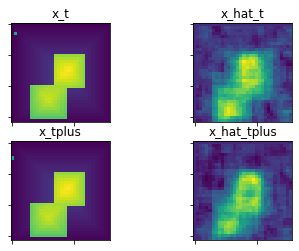

In [66]:
with torch.no_grad():
    test_img = np.random.randint(len(dynamics_test))
    data = torch.as_tensor(dynamics_test[test_img].reshape(1,-1))
    data = data.float()
    x_t = data[:,:x_dim]
    x_tplus = data[:,x_dim:2*x_dim]
    x_empty = data[:,2*x_dim:3*x_dim]
    u_t = data[:,3*x_dim:]

    x_full, z_t, z_tplus, x_hat_full, z_hat_tplus = test_net(x_t, x_tplus, x_empty, u_t)
    
    fig = plt.figure()
    ax = plt.subplot(2,2,1)
    plt.imshow(x_t.reshape(img_res, img_res))
    ax.title.set_text('x_t')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(2,2,2)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(x_hat_full[0,:].reshape(img_res, img_res))
    ax.title.set_text('x_hat_t')
    ax = plt.subplot(2,2,3)
    plt.imshow(x_tplus.reshape(img_res, img_res))
    ax.title.set_text('x_tplus')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax = plt.subplot(2,2,4)
    plt.imshow(x_hat_full[1,:].reshape(img_res, img_res))
    ax.title.set_text('x_hat_tplus')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.show()


In [60]:
opt = np.get_printoptions()
np.set_printoptions(threshold=np.inf, formatter={'float':lambda x: str(x)})
expected = x_t.numpy()
actual = x_hat_full[0,:].numpy()
diff = np.abs(actual - expected)

# Q: Explore the input
# print (expected)
# print ((expected > 30).reshape(32,32))

# Q: How varied are the differences?
print (diff[diff > 2].shape)
print (diff[diff > 10].shape)
print (diff[diff > 20].shape)
print (diff[diff > 30].shape)
print (np.max(diff))

# Q: Is there a high diff at obstacles / robot locations and not so high at empty space?
# A: Doesn't seem to have such a pattern, so nothing conclusive.
# print (diff[expected > 30])

# Q: Is the diff uniformly proportional to input?
# A: Doesn't seem so either...
proportion = diff / expected
# print (proportion)
# print (proportion[proportion >= 1.0])

(821,)
(512,)
(351,)
(186,)
69.818405


In [59]:
print (z_t.numpy())
print (z_tplus.numpy())
print (z_hat_tplus.numpy())
np.set_printoptions(**opt)

[[5.6494027e-05 -1.8525869e-05]]
[[6.1802566e-06 -3.4347177e-06]]
[[0.0 0.0]]


In [ ]:
# Want to use some z_t and a near by value to decode and observe the full states for near by latent states
# However, one problem is decoder network expects an empty image of the full state as input.
some_z_t = np.array([[0.5, 0.5]])
near_by_z_t = some_z_t + np.random.rand(*some_z_t.shape) * (10**-2)
print (near_by_z_t)

In [ ]:
# L2RRT - A lot of this code (except the tensorflow specific code) is taken from source!
plotOn = True
num = 1000
success = False
count_success = 0
max_success = 100
T = 20
connection_radius = 0.15
stepsize = 0.1
radius_goal = 0.1
goal_bias = 0.1
cc_cutoff = 0.9 # only accept edges X likely to be collision free

# initialize empty tree
parents_rrt = np.zeros(num, dtype=int)-1 # index of parent node to each node
zs_rrt = np.zeros((num, z_dim)) # positions in latent space of elements of the tree
costs_rrt = np.zeros(num) # cost of each sample
trajs_rrt = np.zeros((num, T+1, z_dim))
T_rrt = np.zeros(num, dtype=int)
us_rrt = np.zeros((num, u_dim))

if plotOn:
    fig1 = plt.figure(figsize=(14,10), dpi=200)
plotOn and plt.scatter(samples_rrt[:,0], samples_rrt[:,1], color="blue", s=30, alpha=0.01) # current

start_time = time.time()

# choose problem
idx_problem = randint(0,num_problems-1) 
x_init_rrt = x_init_problem[idx_problem,:]
x_goal_rrt = x_goal_problem[idx_problem,:]
xempty_rrt = xempty_problem[idx_problem,:]

# In original, x_empty and u are also passed to this call but I don't see a need to do that, validate by running...
_, zs_local = enc_dyn_net.encode(x_t=x_init_rrt, x_tplus=x_goal_rrt)

zs_rrt[0,:] = zs_local[0,:]
z_goal = zs_local[1,:]

dummy_input_for_goal = np.zeros((1,u_dim))
G_inv_goal = enc_dyn_net.compute_grammian(z_goal, dummy_input_for_goal, self.predict_dynamics(z_goal, dummy_input_for_goal))
dense_CC_conv_out = cc_net.image_representation(xempty_rrt)

itrs_rrt = 1

# explore
for i in range(0,num-1):
    idx_expand = randint(0,num-1)
    sample_expand = samples_rrt[idx_expand,:]
    G_inv_expand = G_inv_rrt[idx_expand,:,:]
    
    if random() < goal_bias:
        sample_expand = z_goal
        G_inv_expand = G_inv_goal
  
    # best near neighbor within ball radius
    neighbors_heap = []
    for nn in range(0,itrs_rrt):
        dz = zs_rrt[nn,:] - sample_expand
        if dz.dot(G_inv_expand).dot(dz) < connection_radius:
            heappush(neighbors_heap,(costs_rrt[nn], nn)) # push 0 in
    
    if len(neighbors_heap) > 0:
        neighbor_entry = heappop(neighbors_heap)
        idx_neighbor = neighbor_entry[1]
    else: # take the nearest node    
        idx_neighbor = -1
        neighbor_cost = np.infty
        for nn in range(0,itrs_rrt):
            dz = zs_rrt[nn,:] - sample_expand
            if dz.dot(G_inv_expand).dot(dz) < neighbor_cost:
                neighbor_cost = dz.dot(G_inv_expand).dot(dz)
                idx_neighbor = nn
    
    z_expand = zs_rrt[idx_neighbor];
    z_expand_idx = idx_neighbor;
    
    # sample controls and forward propagate
    # The may be accelerated by sampling many points in parallel. By then batching the tensorflow call, this shouldn't incur much slowdown
    isFree_expand = True
    uc_expand = np.random.uniform(-stepsize/5,stepsize/5,size=(z_dim))
    T_expand = randint(1,T)
    traj_exp = np.zeros((T+1, z_dim))
    traj_exp[0,:] = z_expand
    
    for t in range(0,T_expand):
        zp_expand = enc_dyn_net.predict_dynamics(z_expand, uc_expand)
        z_expand = zp_expand[0]
        traj_exp[t+1,:] = z_expand
    
    # check collision
    y_CC_expand = cc_net.forward(traj_exp[0:T_expand], traj_exp[1:T_expand+1], np.tile(dense_CC_conv_out[0],(T_expand,1)))
    
    value_CC_expand = 1 / (1 + np.exp(-y_CC_expand))
    isNotFree_expand_t = value_CC_expand < cc_cutoff
    if np.any(isNotFree_expand_t):
        isFree_expand = False
        plotOn and plt.scatter(traj_exp[np.where(isNotFree_expand_t)[0][0],0], 
                               traj_exp[np.where(isNotFree_expand_t)[0][0],1], color="black", s=50, alpha=1)

    # can also add the expanded edge up to the state of collision
    if not isFree_expand: # the connection wasn't successful
        continue;
        
    # add to tree
    costs_rrt[itrs_rrt] = costs_rrt[z_expand_idx] + np.linalg.norm(uc_expand)*T_expand # T_expand + 
    parents_rrt[itrs_rrt] = z_expand_idx
    zs_rrt[itrs_rrt] = zp_expand
    trajs_rrt[itrs_rrt] = traj_exp
    us_rrt[itrs_rrt] = uc_expand
    T_rrt[itrs_rrt] = T_expand
    
    # or don't break and keep going and take the best over time
    if np.linalg.norm(zs_rrt[itrs_rrt,:] - z_goal) < radius_goal:
        if count_success == 0:
            print 'success'
            success = True
        count_success += 1
        if count_success > max_success:
            break;
    
    itrs_rrt += 1
    if np.mod(i,100) == 0:
        print('i = ', i,', t = ', time.time()-start_time)

# plot nodes and costs
max_cost = np.max(costs_rrt)
for i in range(1,itrs_rrt):
    color = costs_rrt[i]/max_cost
    plotOn and plt.scatter(zs_rrt[i,0], zs_rrt[i,1], c=[color, 0, 1-color], s=60, alpha=0.4)
    plotOn and plt.plot(trajs_rrt[i,0:T_rrt[i]+1,0], trajs_rrt[i,0:T_rrt[i]+1,1], c='black', alpha=0.3)
    
# plot solution trajectory
if success:
    # shorest time path
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            tmp_T = 0
            tmp_idx = i
            while not parents_rrt[tmp_idx] == -1:
                tmp_T += T_rrt[tmp_idx]
                tmp_idx = parents_rrt[tmp_idx]
            if tmp_T < best_T:
                best_T = tmp_T
                idx_soln_T = i
            
    # best cost path
    best_T = np.infty
    idx_soln_T = 0
    for i in range(0,itrs_rrt):
        if np.linalg.norm(zs_rrt[i,:] - z_goal) < radius_goal:
            if costs_rrt[i] < best_T:
                best_T = costs_rrt[i]
                idx_soln_T = i
        
    idx = idx_soln_T
    while not parents_rrt[idx] == -1:
        plotOn and plt.plot(trajs_rrt[idx,0:T_rrt[idx]+1,0], trajs_rrt[idx,0:T_rrt[idx]+1,1], c='green', alpha=0.8, linewidth=5)
        idx = parents_rrt[idx]
else: 
    print "failure :("

plotOn and plt.scatter(zs_rrt[0,0], zs_rrt[0,1], color="green", s=500, alpha=0.8) # plot init
plotOn and plt.scatter(z_goal[0], z_goal[1], color="red", s=500, alpha=0.8) # plot init
plotOn and plt.show()